# KSA206: Polar Observations and Modelling

# Week 5 - Multiple CTDs

In `1_Introduction_to_CTDs.ipynb` we worked with a single CTD profile. Hopefully you now understand:

1. How the CTD files are structured, what dimensions and variables they contain.
2. How to plot those variables, and calculate density using the `gsw` library.
3. How to compare sensor data with the water samples from the Niskin bottles.

In this notebook we are going to level up a bit and look at a *multiple* different profiles from the same oceanographic voyage, the Multidisciplinary Investigations of the Southern Ocean [(MISO)](https://aappartnership.org.au/miso/). 

## Load libraries and data

We have imported new libraries. *Use [CoPilot](https://copilot.microsoft.com/) to understand what they are used for.*

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import datetime
import glob
import gsw
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.cm import ScalarMappable

First of all, we need to load all of our CTDs. Remember that to open, we need to use `xr.open(path_to_file)`. We have 22 different profiles in our `data` directory (sometimes you might have hundreds of files!), so instead of typing one by one, we will:

1. Use `glob` to create a list with the file names
2. Use `numpy` sort it in alphabetical order
3. Iterate through the list in order to open the CTD files and save them to a dictionary.

A dictionary is simply a collection of data callable by "keys". It allows to collect data that does not have the same size, shape or dimensions, which is useful for us since the CTD profiles have different depths, some are shallower and some go deeper.

In [3]:
# Create a list of paths
path_to_files = glob.glob('data/*Ctd*') 

In the above, the * serve as a wildcard. we're asking to list all the files that have `something Ctd something` in their name. This is because we have other files in our folder (HydroChem) which we'd like to ignore.

In [4]:
# Sort paths in descending order
path_to_files = np.sort(path_to_files)
# Initialise dictionary
CTDs = {}
# Iterate to open each file and save it to the dictionary
for i in range(0, len(path_to_files)):
    CTDs[i] = xr.open_dataset(path_to_files[i])

## Characterising our dataset 

We have opened a bunch of CTD profiles, but we don't know anything about them. We would like to know where these profiles where taken, and possibly also what day. This information is important to contextualise the data. 

### Location of profiles

Let's create a map where we can see the locations of all CTD profiles in our dataset. First, let's iterate through are CTD profiles to get (a) latitude, (b) longitude and (c) date information for each profile.

Create empty lists of lat, lon and data:

In [5]:
lat = []
lon = []
time = []

Iterate through the profiles, extract that information and append it to the list:

In [6]:
for i in range(0, len(CTDs)):
    lat.append(CTDs[i]['latitude'].values)
    lon.append(CTDs[i]['longitude'].values)
    time.append(CTDs[i]['time'].values)

The `.values` part extracts the value of that variable, and drops dimension and coordinate information as well as metadata. Compare:

In [7]:
CTDs[0]['latitude'].values

array([-66.47646332])

In [8]:
CTDs[0]['latitude']

<xarray.DataArray 'latitude' (latitude: 1)>
array([-66.476463])
Coordinates:
  * latitude  (latitude) float64 -66.48
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north
    data_min:       -66.4764633178711
    data_max:       -66.4764633178711
    valid_range:    [-90.  90.]

Now that we have extracted the information, let's plot the locations:

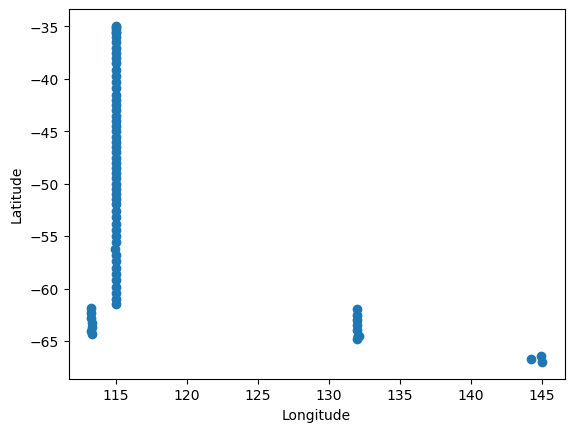

In [9]:
plt.scatter(lon, lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

We can do better than that! Although technically correct, it would be ideal to have a map instead of an empty plot, where we can see the continents for reference. Otherwise it is hard to understand these locations without any reference points.

We will create a map using the `cartopy` library. `cartopy` is great. It allows to easily plot maps with a lot of [different projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html) with a lot of customization possible to get a better-looking map with which to showcase your data in the most effective way.

We will use the `PlateCarree` projection, defined in the `fig.add_subplot(projection)` line. You will notice that doing a map involves a few more lines of code than our simple initial scatter plot, but the good thing is that once you have a map drawn just as you like it, you can just copy-paste it between code cells.

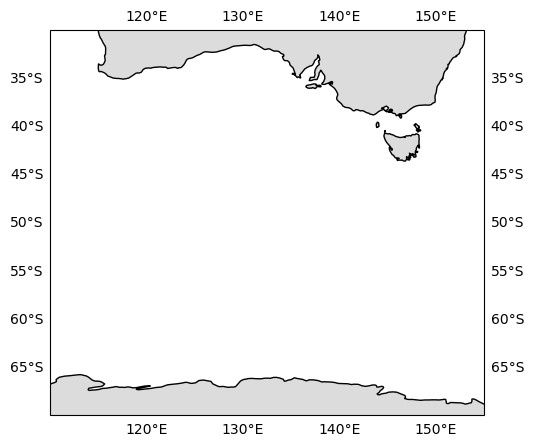

In [11]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
# Set the limits of the map [longitude_west, longitude_east, latitude_south, latitude_north]
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
# Draw the land in grey with edges in black at 50m resolution
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
# Add gridlines with latitude, longitude ticks
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

<h4 style="color: red;">Question 1</h4>

Try [other projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html) from `cartopy`, see if you can change the colour of the land, etc. Which one do you think is more appropriate to use in this case?

*Answer here*

Our map looks great, but we can make it even better. Let's plot the ocean's bathymetry in the background, to have topographic features (such as mid-ocean ridges) as reference. 

First open the bathymetry file:

In [12]:
bathymetry = xr.open_dataset('data/ETOPO_2022_v1_bed.nc')

And now we can copy the code above we used to create the map, and on top plot the bathymetry - called `z` in our `bathymetry` dataset. Note a couple of things in our plotting function:

 - We are using `pcolormesh`, which is a function used to plot 2 dimensional data. You can take a look at other plotting options [here](https://matplotlib.org/stable/gallery/index.html#images-contours-and-fields).
 - Within our `pcolormesh` function there is a `transform = ccrs.PlateCarree()` argument. When plotting using `cartopy`, this **always** has to be there, independently of the `projection` defined in the subplot. Otherwise, your map will fail. 

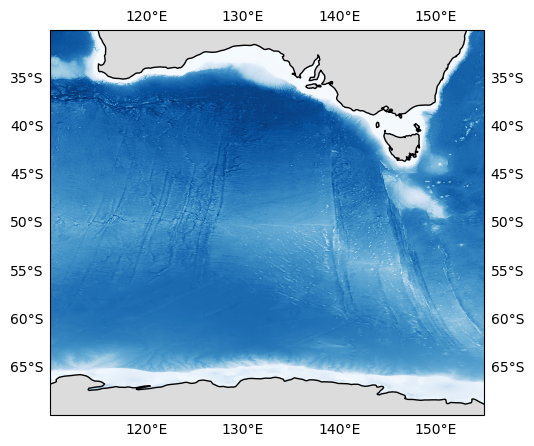

In [13]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
# Set the limits of the map [longitude_west, longitude_east, latitude_south, latitude_north]
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
# Draw the land in grey with edges in black at 50m resolution
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
# Add gridlines with latitude, longitude ticks
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

# Plot the bathymetry
bathymetry['z'].plot.pcolormesh(ax = ax, add_colorbar = False, 
                                cmap = 'Blues_r', vmax = 0.1, vmin = -6000,
                                transform = ccrs.PlateCarree());

<h4 style="color: red;">Question 2</h4>

In the figure below, we have replaced `pcolormesh` by `contourf`. What is the difference? Which one do you think is better and why?

*Answer here*

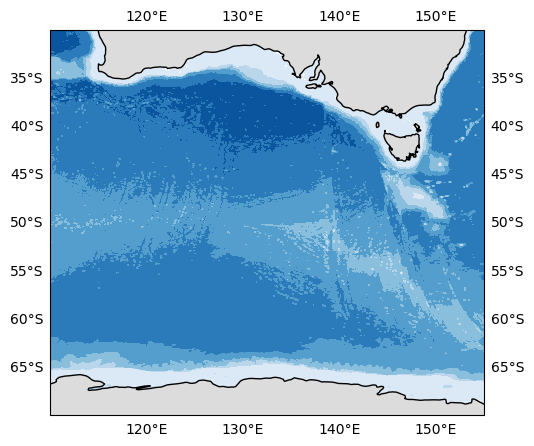

In [14]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
# Set the limits of the map [longitude_west, longitude_east, latitude_south, latitude_north]
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
# Draw the land in grey with edges in black at 50m resolution
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
# Add gridlines with latitude, longitude ticks
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

# Plot the bathymetry
bathymetry['z'].plot.contourf(ax = ax, add_colorbar = False, 
                              cmap = 'Blues_r', vmax = 0.1, vmin = -6000,
                              transform = ccrs.PlateCarree());

Now that we are satisfied with our map, we can plot the location of our CTD stations. We will do this with a `scatter` plot, which uses markers for each of our `lon`, `lat` pairs. There's a lot of customization that can be done to the markers, but we will start by plotting the locations with red crosses. Remember the `transform = ccrs.PlateCarree()` argument within your plotting function!

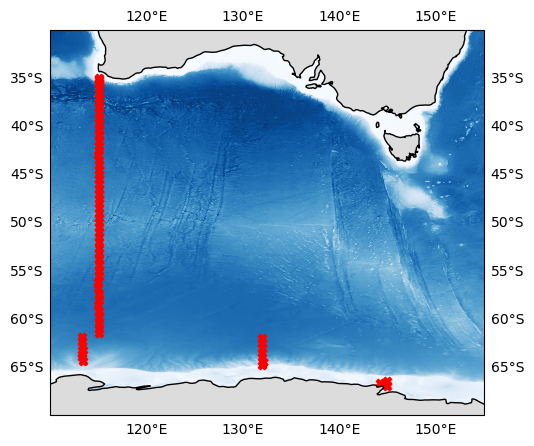

In [15]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
# Set the limits of the map [longitude_west, longitude_east, latitude_south, latitude_north]
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
# Draw the land in grey with edges in black at 50m resolution
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
# Add gridlines with latitude, longitude ticks
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

# Plot the bathymetry
bathymetry['z'].plot.pcolormesh(ax = ax, add_colorbar = False, 
                                cmap = 'Blues_r', vmax = 0.1, vmin = -6000,
                                transform = ccrs.PlateCarree());
# Plot CTD locations
ax.scatter(lon, lat, marker = 'X', color = 'red', transform = ccrs.PlateCarree());

This is awesome! 

We can see that a little group of profiles was taken at the Antarctic continental shelf, near the Mertz Glacier. This is a very interesting location, where around 10 years ago there used to be a glacier "tongue", extending from the land onto the ocean... until it was hit by a giant iceberg of 100km by 40km in size. The collision "calved", or broke off, the glacier tongue, which then became stuck in a shallow depth nearby. You can see satellite images of the calving event [here](https://earthobservatory.nasa.gov/images/42819/collision-calves-iceberg-from-mertz-glacier-tongue-antarctica).

Another group of CTD profiles were taken closer to 130E, not quite at the continental shelf, but still very close to Antarctica. And then we have a larger group of profiles up north, closer to Western Australia. 

We can tweak our map, colouring each station differently, for example by date, to tease them apart. For that we will use a colormap. We will use the default one, `viridis`, but there are many options available. You can view and choose a colormap [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html). **Remember to choose colorblind friendly ones. `jet` is a popular colormap, but a terrible choice regarding colorvision accessibility.**

To assign colours using dates is not trivial, because dates are not numerical values. What we can do, is calculate how many days have passed since the first CTD profile was taken, which will leave us with a "numerical" reference. We can then use these numbers to "sample" a colormap:

In [17]:
# A for-loop that calculates the number of days since the first profile
days_since_first = np.array([(time[i]-time[0]).astype('timedelta64[D]').astype(int)[0] for i in range(0, len(time))])
days_since_first

array([ 0,  0,  1,  9, 10, 10, 11, 11, 12, 12, 13, 14, 17, 18, 18, 19, 19,
       20, 20, 22, 22, 22, 23, 23, 24, 24, 25, 26, 28, 28, 29, 30, 31, 32,
       32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 36, 37, 37, 38, 38, 38, 39,
       39, 39, 40, 40, 41, 41, 41, 42, 42, 42, 43, 44, 44, 44, 45, 46, 46,
       46, 46, 47, 47])

Now we can sample our colourmap with the `days_since_first`, dividing it's maximum value to normalise the array (making it go from 0 to 1):

In [18]:
colours = plt.get_cmap('viridis')(days_since_first/np.max(days_since_first))

This creates an array of dates and formats them to use for the colorbar. The first line starts from the date of the first CTD profile, and adds 5 days until the last profile. And the second line puts it in yyyy-mm-dd format:

In [19]:
dates = np.arange(time[0][0], time[-1][0], datetime.timedelta(days = 5))
dates_formatted = [str(date)[:10] for date in dates]

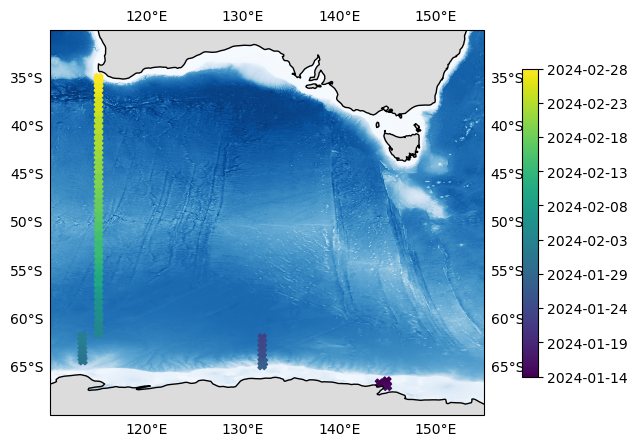

In [20]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
# Set the limits of the map [longitude_west, longitude_east, latitude_south, latitude_north]
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
# Draw the land in grey with edges in black at 50m resolution
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
# Add gridlines with latitude, longitude ticks
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

# Plot the bathymetry
bathymetry['z'].plot.pcolormesh(ax = ax, add_colorbar = False, 
                                cmap = 'Blues_r', vmax = 0.1, vmin = -6000,
                                transform = ccrs.PlateCarree());
# Plot the CTD locations
loc_plot = ax.scatter(lon, lat, c = colours, marker = 'X', transform = ccrs.PlateCarree());
# Add a colorbar
cbar = plt.colorbar(loc_plot, shrink = 0.8)
cbar.set_ticks(np.linspace(0, 1, len(dates)))
cbar.set_ticklabels(dates_formatted)

Note that the creation of the colorbar and its ticks is a bit involved. This is because we are working with `datetime` format which is not always easy to use when plotting. You want, use [CoPilot](https://copilot.microsoft.com/) to understand better what each line does! 

## Plot the data

Now that we know a bit when and where these CTD profiles where taken, let's try different ways of visualising the observations. Let's start by calculating potential densities using the `gsw` library and doing a similar figure to the one in `Introduction_to_CTDs.ipynb`.

We will continue using dictionaries to avoid issues due to the varying depths between stations.

In [21]:
temperature = {}; salinity = {}; density = {}
absolute_salinity = {}; conservative_temperature = {}
for i in range(0, len(CTDs)):
    temperature[i] = CTDs[i]['temperature']
    salinity[i] = CTDs[i]['salinity']

    absolute_salinity[i] = gsw.SA_from_SP(salinity[i], CTDs[i]['pressure'], CTDs[i]['longitude'], CTDs[i]['latitude'])
    absolute_salinity[i] = absolute_salinity[i]

    conservative_temperature[i] = gsw.CT_from_t(absolute_salinity[i], temperature[i], CTDs[i]['pressure'])
    conservative_temperature[i] = conservative_temperature[i]
        
    density[i] = gsw.sigma0(absolute_salinity[i], conservative_temperature[i])
    density[i] = density[i].rename('density')

Now let's plot temperature, salinity and density as a function of depth:

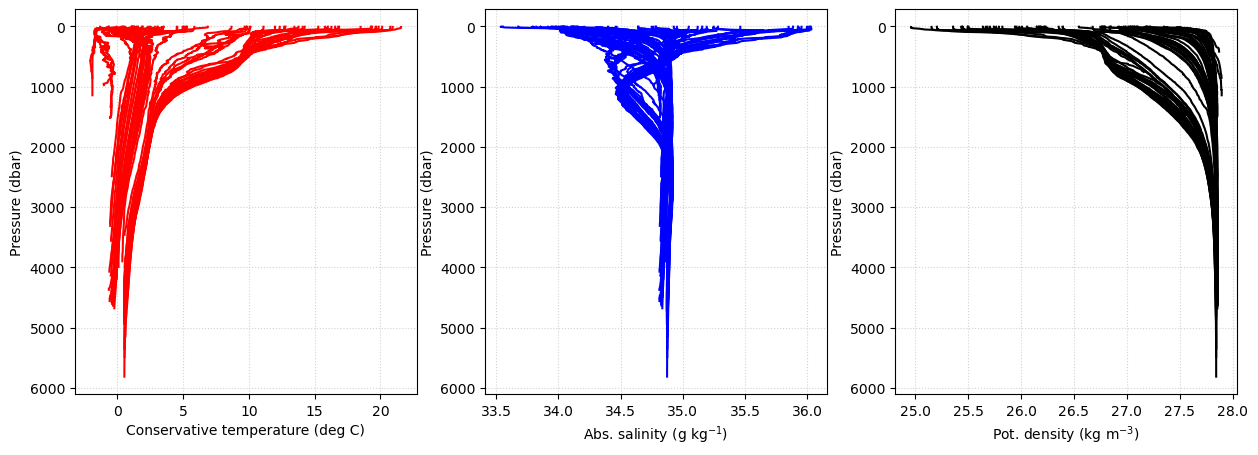

In [23]:
# Create a figure instance with 3 axis arranged in 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize = (15,5))

# Iterate through profiles to plot
for i in range(0, len(CTDs)):
    conservative_temperature[i].plot(ax = axs[0], y = 'pressure', color = 'red', label = None)
    absolute_salinity[i].plot(ax = axs[1], y = 'pressure', color = 'blue')
    density[i].plot(ax = axs[2], y = 'pressure', color = 'k')

# Iterate through axis to add gridlines, make surface at the top, etc
for ax in axs:
    ax.grid(linestyle = ':', color = 'lightgrey')
    ax.invert_yaxis()
    ax.set_ylabel('Pressure (dbar)')   
    ax.set_title('') 

# Label each axis
axs[0].set_xlabel('Conservative temperature (deg C)')
axs[1].set_xlabel('Abs. salinity (g kg$^{-1}$)')
axs[2].set_xlabel('Pot. density (kg m$^{-3}$)');

<h4 style="color: red;">Question 3</h4>

Looking at the profiles above, can you figure out which ones correspond to each of the three regions on the map we made? Plot the figure but with a different color for each profile's time, like we did for the locations in the map.

*Tip: you will need to use `colour = colours[i]` somewhere in your code.*

*Answer here*

## Temperature salinity diagrams

Temperature-salinity diagrams, usually called T-S diagrams, are made by plotting temperature as a function of salinity. They allow us to condense the information in the profile plots we've been doing in just one figure, and since water masses are usually defined using both variables, they are widely used in oceanographyfor the purpose of water mass identification.

Let's start by plotting a simple T-S of all our CTD profiles, coloured by the date they've been taken. You'll notice that the way of setting the colorbar is a bit different than before, use [CoPilot](https://copilot.microsoft.com/) if you want to understand what these new lines do.

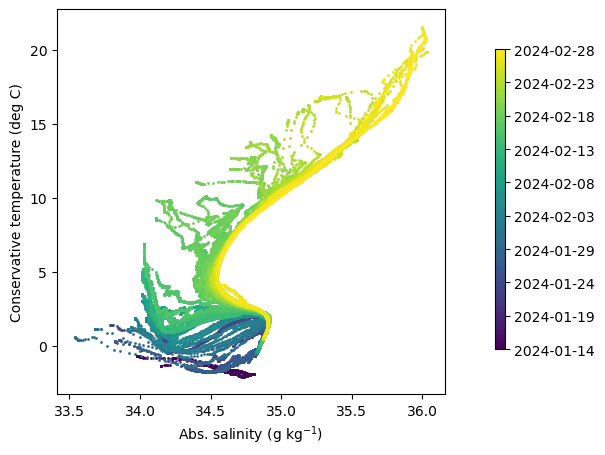

In [26]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()

for i in range(0, len(CTDs)):
    ax.scatter(absolute_salinity[i], conservative_temperature[i], s = 1, color = colours[i])

ax.set_xlabel('Abs. salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative temperature (deg C)');

# Colorbar
cax = fig.add_axes([1.0, 0.2, 0.02, 0.6])
mapper = ScalarMappable(cmap = 'viridis')
mapper.set_array(days_since_first/np.max(days_since_first))
cbar = plt.colorbar(mapper, cax = cax)
cbar.set_ticks(np.linspace(0, 1, len(dates)))
cbar.set_ticklabels(dates_formatted)

There is one key ingredient missing in this T-S diagram: density. As you know from what we've done before using the `gsw` library, density is a function of temperature and salinity. So, it becomes clear that we can add density to this plot as well and use it as another reference for our profiles.

The way of doing this is by calculating potential density using the values of temperature and salinity in our T-S axis. This will give us a 2-D potential density field, which we can plot on the back using a `contour` plot, which is essentially plotting lines of equal values.

Let's create the density array:

In [27]:
# Get temperature/salinity edges from the axis
temp_range = ax.get_ylim()
salt_range = ax.get_xlim()

# Get an array of size 50 between the edges
temp_axis = np.linspace(temp_range[0], temp_range[1], 50)
salt_axis = np.linspace(salt_range[0], salt_range[1], 50)

# Create a grid and calculate potential density
temp_axis, salt_axis = np.meshgrid(temp_axis, salt_axis)
density_reference = gsw.sigma0(salt_axis, temp_axis)

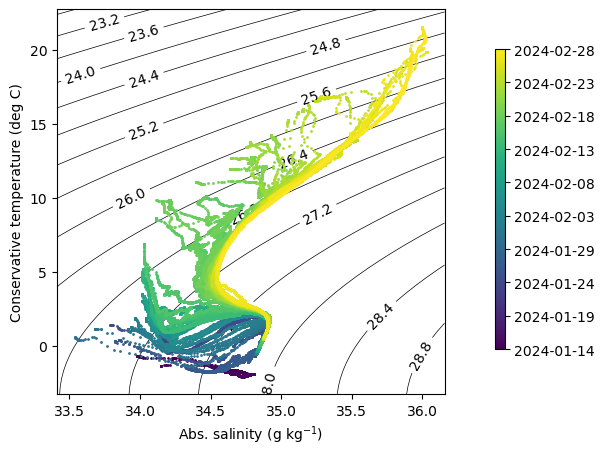

In [28]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()

pref = ax.contour(salt_axis, temp_axis, density_reference, levels = 15, 
                  colors = ['k'], linewidths = [.5], zorder = 0)
plt.clabel(pref, inline = True, zorder = 0)

for i in range(0, len(CTDs)):
    ax.scatter(absolute_salinity[i], conservative_temperature[i], s = 1, color = colours[i])

ax.set_xlabel('Abs. salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative temperature (deg C)');

# Colorbar
cax = fig.add_axes([1.0, 0.2, 0.02, 0.6])
mapper = ScalarMappable(cmap = 'viridis')
mapper.set_array(days_since_first/np.max(days_since_first))
cbar = plt.colorbar(mapper, cax = cax)
cbar.set_ticks(np.linspace(0, 1, len(dates)))
cbar.set_ticklabels(dates_formatted)

<h4 style="color: red;">Question 4</h4>

Can you identify the following regions in the T-S diagram?
- Stably vs unstably stratified areas
- Thermocline/pycnocline

Using the above considerations, can you describe in a few words the differences in the water column between the three CTD regions?

*Answer here*

### Making TS diagrams even better

T-S digrams are pretty powerful. Instead of having separate panels for each variable, we can throw in temperature, salinity and density all together, which is key since water masses are usually defined as from a combination of those. 

The ability to colour the profiles by an extra variable makes them even more useful. We have chosen to colour by the date the profile was taken, but there are many more options. This is going to be a bit different from plotting 

I have asked [CoPilot](https://copilot.microsoft.com/) to help me with the following prompt:

*"I want to do a scatter plot with pyplot, where I am plotting X vs Y, and I'd like the marker to be colored according to a third variable Z with max and min colors defined by me. How can I do that?"*

This was the answer:

```
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
np.random.seed(42)
n_points = 100
X = np.random.rand(n_points) * 10
Y = np.random.rand(n_points) * 10
Z = np.random.rand(n_points) * 100  # Third variable (color)

# Define custom colormap
cmap = plt.get_cmap("coolwarm")

# Normalize Z to [0, 1] for colormap
norm = plt.Normalize(Z.min(), Z.max())

# Create scatter plot
plt.scatter(X, Y, c=Z, cmap=cmap, norm=norm, s=50, edgecolor="k")

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Z values")

# Set axis labels
plt.xlabel("X")
plt.ylabel("Y")

# Set title
plt.title("Scatter Plot with Custom Colored Markers")

# Show the plot
plt.show()

```

We need to tweak it a little bit, because we want to plot *multiple* CTDs, not just one, and we'd like to normalise by depth levels defined by us.

In [29]:
# Define min (surface) and max (largest depth I want to appear in my colormap):
vmin = 0
vmax = 4000
norm = plt.Normalize(vmin, vmax)

Now we are ready to plot:

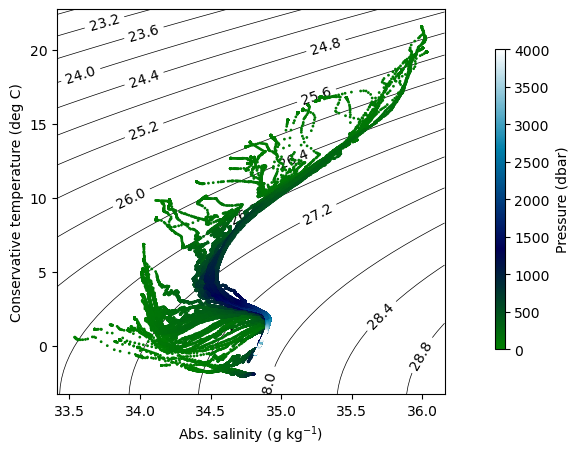

In [30]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()

pref = ax.contour(salt_axis, temp_axis, density_reference, levels = 15, 
                  colors = ['k'], linewidths = [.5], zorder = 0)
plt.clabel(pref, inline = True, zorder = 0)

for i in range(0, len(CTDs)):
    ax.scatter(absolute_salinity[i], conservative_temperature[i], 
               c = CTDs[i]['pressure'], cmap = 'ocean', norm = norm, s = 1)

ax.set_xlabel('Abs. salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative temperature (deg C)');

# Let's create a scatter with no markers (setting size s = 0) for the colorbar
im = ax.scatter(np.linspace(34, 35, vmax), np.linspace(0, 15, vmax), 
                c = np.arange(vmin, vmax, 1), s = 0, cmap = 'ocean')

cax = fig.add_axes([1.0, 0.2, 0.02, 0.6])
cbar = plt.colorbar(im, cax = cax)
cbar.set_ticks(np.arange(vmin, vmax+500, 500))
cbar.set_label('Pressure (dbar)');

<h4 style="color: red;">Question 5</h4>

Instead of colouring by pressure, look at what other variables our CTD profiles have, and choose another (i.e. oxygen, nutrients). Play around with `vmin`, `vmax` to get the most out of your plot, choose different colormaps (the ones we've used so far are not that exciting), etc. 

*Answer here*